# CASE STUDY BI PART

> ### This notebook consists three parts :
> 1. Visualize traffic in all channels 

> 2. Visualize the Conversion Rates in each onboarding steps 

> 3. Analysis the causing of low conversion rate in the process (Given the sparsity of the dataset, this analysis only using the Organic traffic)

> 4. (optional) Time analysis on each channel  

###### Before each section started, assumptions and steps are wroted in the beginning

The funnel of this onboarding process is 
app opening -> answer a series of questions -> if supproted, jumping to signup page -> finsih sign up 

                                                               -> else stop at here
                                                       
                                                       
The coming traffic consists of two group of users, one is eligible for signing up, the other one is not. 


The objectness here is to increase the conversertion rate (signup / total incoming users).




If the app lost an noticebale amount of user before "serviceContinueSuccess" step, which is the place to determine if a user is eligble for the service,
that means the steps before it went wrong;

If the app lost an large amout of user after confirmed that they are eligible，then the problem can be the signup page 



In the given dataset, it contains the user attributed channel, e.g., facebook install, instagram install, snapchat install, blog,etc., but users from all the channels are the same in the sense that they will find out if they are eligble for the service during the process of answering the onboarding questions.

A problem can be, after a facebook campain, a group of people who are trading stocks saw the app ad and dowloaded it. However, they are not eligble for the service. In this case, the population of new coming user is large, but the conversertion rate is low. Can we say, ad from Facebook is not working? because we are reaching out to people that cannot signup for the service. Shall we stop ad on Facebook?

The group of people we should focus on is the people who are supported by the service and study why they decided not to.




**It seems to be, the onboarding process is too complex**, it will be **better** if users can find out weather they are supported by the service or not at the very begining of the process

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
rcParams.update({'figure.autolayout': True})
%matplotlib inline

In [2]:
rcParams['figure.figsize'] = 8, 6
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

## 1) BI PART

In [3]:
user_channel = pd.read_csv("User_channels.csv",delimiter=",")
user_conv = pd.read_csv("User_journey.csv",delimiter=',') 

In [4]:
print(user_channel.head())
print(user_conv.head())

                           anonymous_id     attributed_channel
0  0000A0C6-9361-4D49-89CF-26CF45C405D1     Instagram Installs
1  0001A23F-2B57-4C83-A9B2-0312410256BB   Adwords UAC Installs
2  0002AB38-AB1D-43AB-AF2E-1A301B8C54F2                Organic
3  0002DEB7-F955-409A-A725-1DD68E82DAB8  Off-Facebook Installs
4  000365EF-E564-4E3C-91AA-FDFF0ED07C59                Organic
                           anonymous_id                event_text                      timestamp language os_name
0  008B280E-E055-46C3-AFB7-AC134D3D12A8                   appOpen  2018-01-04T20:13:51.246+01:00   German     iOS
1  008B280E-E055-46C3-AFB7-AC134D3D12A8     Application Installed  2018-01-04T20:13:51.266+01:00   German     iOS
2  008B280E-E055-46C3-AFB7-AC134D3D12A8  sectionOnboardingSlide 0  2018-01-04T20:13:59.909+01:00   German     iOS
3  008B280E-E055-46C3-AFB7-AC134D3D12A8      sectionNotifications  2018-01-04T20:14:07.456+01:00   German     iOS
4  008B280E-E055-46C3-AFB7-AC134D3D12A8        appSe

#### Descriptive Stats for user_channel

In [5]:
print(user_channel.describe())

                                anonymous_id attributed_channel
count                                    100                100
unique                                   100                 14
top     000646F3-889E-4C36-BB4C-FA6778FAB240            Organic
freq                                       1                 53


In [6]:
print(user_channel.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
anonymous_id          100 non-null object
attributed_channel    100 non-null object
dtypes: object(2)
memory usage: 1.6+ KB
None



### 1.11) Bring the most traffic to our app and generate installs

In [7]:
user_channel.groupby(['attributed_channel']).size().sort_values(ascending=False)

attributed_channel
Organic                        53
Instagram Installs             12
Facebook Installs              12
Off-Facebook Installs           6
Twitter Installs                4
Liftoff                         4
Leverate_CPI-3                  2
Website                         1
Snapchat Installs               1
Smartbanner                     1
Facebook Messenger Installs     1
Blog_Posts                      1
Adwords UAC Installs            1
Adwords Search                  1
dtype: int64

In [8]:
df = user_channel.groupby(['attributed_channel'])['anonymous_id'].count().reset_index(name='count')\
                        .sort_values(['count'], ascending=False) 

/Users/Tison/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


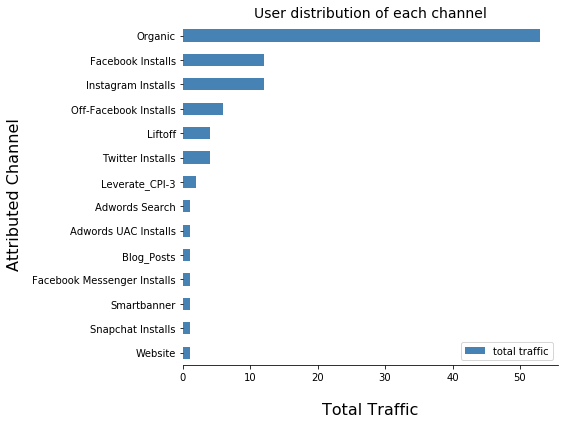

In [9]:
ax = df.plot.barh(x='attributed_channel',y='count',color='steelblue')
ax.invert_yaxis()
ax.set_title('User distribution of each channel',fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylabel("Attributed Channel", fontsize=16,labelpad=10)
ax.set_xlabel("Total Traffic", fontsize=16,labelpad=20)

ax.legend(['total traffic'])
plt.savefig('task1_1')


### 1.12) Show the highest Acquisition Rate (conversion rate from install to sign up success)


> merge two table, User_channel and User_journey to have the extra infomation about on_boarding process

>  first, add a new boolean column 'converted'. if the user finished all steps,i.e, values in 'event_text' contain 'signUpSuccess',  then the value in column 'converted' is 1, else it is 0 

>    second, group the data based on the user anonymous_id, so we can tell which user has converted. (the number of user after grouping is supposed to be equal to the number of unique user we observed in the begining)
    
    
>    finnaly, group the data from second step based on attributed_channel and compute mean value on 'converted'

> In addition, add one sanity check to make sure the mentationed computation is correct

In [10]:
join_table = pd.merge(user_channel,user_conv,on='anonymous_id')

In [11]:
join_table.head()

,anonymous_id,attributed_channel,event_text,timestamp,language,os_name
0,0000A0C6-9361-4D49-89CF-26CF45C405D1,Instagram Installs,appOpen,2018-05-28T13:16:08.336+02:00,German,iOS
1,0000A0C6-9361-4D49-89CF-26CF45C405D1,Instagram Installs,Application Installed,2018-05-28T13:16:08.364+02:00,German,iOS
2,0000A0C6-9361-4D49-89CF-26CF45C405D1,Instagram Installs,sectionOnboardingSlide 0,2018-05-28T13:16:10.687+02:00,German,iOS
3,0000A0C6-9361-4D49-89CF-26CF45C405D1,Instagram Installs,Install Attributed,2018-05-28T13:16:16.719+02:00,German,iOS
4,0000A0C6-9361-4D49-89CF-26CF45C405D1,Instagram Installs,sectionNotifications,2018-05-28T13:16:30.107+02:00,German,iOS


In [12]:
join_table['converted'] = join_table['event_text'].apply(lambda x: 1 if x=='signUpSuccess' else 0)

In [13]:
user_signup = join_table.groupby(['attributed_channel','anonymous_id'])['converted'].sum().reset_index()

In [14]:
channel_conversion = user_signup.groupby(['attributed_channel'])['converted'].mean().round(2).reset_index(name='conversion_rate')

In [15]:
channel_conversion.sort_values('conversion_rate',ascending=False)

,attributed_channel,conversion_rate
13,Website,1.00
3,Facebook Installs,0.33
8,Off-Facebook Installs,0.33
9,Organic,0.09
5,Instagram Installs,0.08
0,Adwords Search,0.00
1,Adwords UAC Installs,0.00
2,Blog_Posts,0.00
4,Facebook Messenger Installs,0.00
6,Leverate_CPI-3,0.00


#### Sannity check:
> check in the joined table when 'attributed_channel' is 'Website', whether all unique anonymous_id have finsihed all steps 

In [16]:
join_table.query('attributed_channel =="Website"')['anonymous_id'].nunique() == \
join_table.query('attributed_channel =="Website"').query('event_text == "signUpSuccess"')['anonymous_id'].nunique()

True

In [17]:
join_table[join_table['attributed_channel']=='Website']

,anonymous_id,attributed_channel,event_text,timestamp,language,os_name,converted
1688,00A8A726-BEF0-43F1-A212-B1C713C2A612,Website,appOpen,2018-03-24T16:26:44.228+01:00,German,iOS,0
1689,00A8A726-BEF0-43F1-A212-B1C713C2A612,Website,Application Installed,2018-03-24T16:26:44.259+01:00,German,iOS,0
1690,00A8A726-BEF0-43F1-A212-B1C713C2A612,Website,sectionOnboardingSlide 0,2018-03-24T16:26:49.041+01:00,German,iOS,0
1691,00A8A726-BEF0-43F1-A212-B1C713C2A612,Website,sectionOnboardingSlide 1,2018-03-24T16:27:01.443+01:00,German,iOS,0
1692,00A8A726-BEF0-43F1-A212-B1C713C2A612,Website,sectionOnboardingSlide 2,2018-03-24T16:27:03.276+01:00,German,iOS,0
1693,00A8A726-BEF0-43F1-A212-B1C713C2A612,Website,sectionNotifications,2018-03-24T16:27:04.067+01:00,German,iOS,0
1694,00A8A726-BEF0-43F1-A212-B1C713C2A612,Website,sectionNotificationAccepted,2018-03-24T16:27:13.235+01:00,German,iOS,0
1695,00A8A726-BEF0-43F1-A212-B1C713C2A612,Website,sectionChooseFirstTaxYear,2018-03-24T16:27:33.680+01:00,German,iOS,0
1696,00A8A726-BEF0-43F1-A212-B1C713C2A612,Website,firstTaxYearChosen,2018-03-24T16:27:36.354+01:00,German,iOS,0
1697,00A8A726-BEF0-43F1-A212-B1C713C2A612,Website,Install Attributed,2018-03-24T16:27:38.773+01:00,German,iOS,0


### Conclusion for 1.1) and 1.2)

#### Organic is the channel brings the most traffic  (53%)
#### However, Organic is not the one has the highest overall Acquistion Rate. Need to further analysis the causing.
#### Website is the channel having 100% Acquistion Rate, but only 1% of the traffic comes from Website. Since the traffic is so small in the given data, it is hard to gain insight. 


The following blocks are only for plotting

And we are interested only in channels that have conversersion rate

/Users/Tison/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


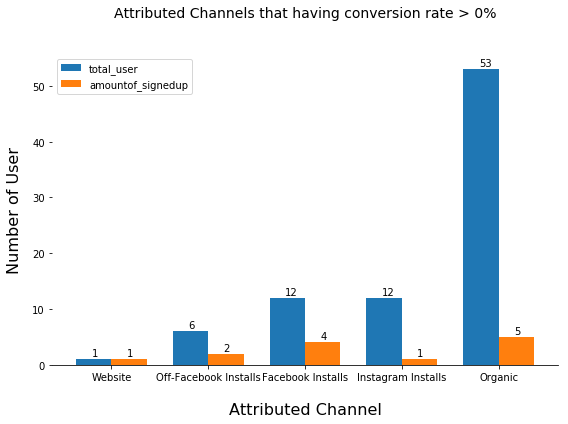

In [18]:
traffice_conversion= pd.merge(df, channel_conversion, on='attributed_channel')
traffice_conversion = traffice_conversion.rename(columns={'count':'total_user'})
traffice_conversion['amountof_signedup'] = round(traffice_conversion['total_user'] * traffice_conversion['conversion_rate'])
traffice_conversion_plot = pd.melt(traffice_conversion[['attributed_channel','total_user','amountof_signedup']],id_vars =['attributed_channel'])
traffice_conversion_plot = traffice_conversion_plot.set_index(['attributed_channel', 'variable']).value.unstack()


traffice_conversion_plot.columns = pd.CategoricalIndex(traffice_conversion_plot.columns.values,
                                 ordered=True,
                                 categories=['total_user','amountof_signedup'])
traffice_conversion_plot= traffice_conversion_plot.sort_index(axis=1)
traffice_conversion_plot = traffice_conversion_plot[traffice_conversion_plot['amountof_signedup']>0]
traffice_conversion_plot = traffice_conversion_plot.iloc[np.argsort(traffice_conversion_plot.amountof_signedup / traffice_conversion_plot.total_user).values[::-1]]
color = ['tab:blue','tab:orange']
ax = traffice_conversion_plot.sort_values('total_user',ascending=True).plot.bar(width=0.73,color=color,rot=0)
ax.set_ylabel("Number of User", fontsize=16,labelpad=10)
ax.set_xlabel("Attributed Channel", fontsize=16,labelpad=20)
ax.set_title("Attributed Channels that having conversion rate > 0%",fontsize=14).set_position([.5, 1.1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)


for i in ax.patches:
    ax.text(i.get_x()+0.16, i.get_height()+.5, \
            str(int((i.get_height()))), color='black')

plt.savefig('task1_2')

In [19]:
traffice_conversion_plot

,total_user,amountof_signedup
attributed_channel,,
Website,1.0,1.0
Off-Facebook Installs,6.0,2.0
Facebook Installs,12.0,4.0
Organic,53.0,5.0
Instagram Installs,12.0,1.0


#### 1.2) Visualize the Conversion Rates of each of the events/steps in the onboarding
> overall conversion rates of each steps 

> break down into segmentation : conversion rates of each steps of each channel for channels having conversersion rate.

Only take 
'appOpen','Application Installed','sectionChooseFirstTaxYear', 'firstTaxYearChosen','lastWhoAreYouSeen','lastWhoAreYouAnswered','serviceContinueSuccess','sectionSignUp','signUpSuccess' 
as revelant steps for the analysis

In [20]:
user_conv['timestamp']= pd.to_datetime(user_conv['timestamp'])

In [21]:
step_conv = user_conv.groupby(['event_text'])['anonymous_id'].nunique().reset_index(name='unique_user')

In [22]:
step_conv

,event_text,unique_user
0,Application Installed,100
1,Install Attributed,97
2,appClosed,6
3,appOpen,100
4,appSetToBackground,97
5,firstTaxYearChosen,92
6,lastWhoAreYouAnswered,78
7,lastWhoAreYouSeen,79
8,sectionChooseFirstTaxYear,93
9,sectionNotificationAccepted,44


In [23]:
funnel =['appOpen','Application Installed','sectionOnboardingSlide 0','sectionOnboardingSlide 1','sectionOnboardingSlide 2',\
         'sectionChooseFirstTaxYear','firstTaxYearChosen','lastWhoAreYouSeen','lastWhoAreYouAnswered',\
         'serviceContinueSuccess','sectionSignUp','signUpSuccess']

In [24]:
step_conv['event_text'] = pd.Categorical(step_conv['event_text'], funnel)
step_conv=step_conv.sort_values('event_text').dropna()
step_conv.reset_index(drop=True, inplace=True)

In [25]:
step_conv['last_event_user'] =  step_conv['unique_user'].shift(periods=1)

In [26]:
step_conv['conv_rate'] = round(step_conv['unique_user']/step_conv['last_event_user'],2)

/Users/Tison/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


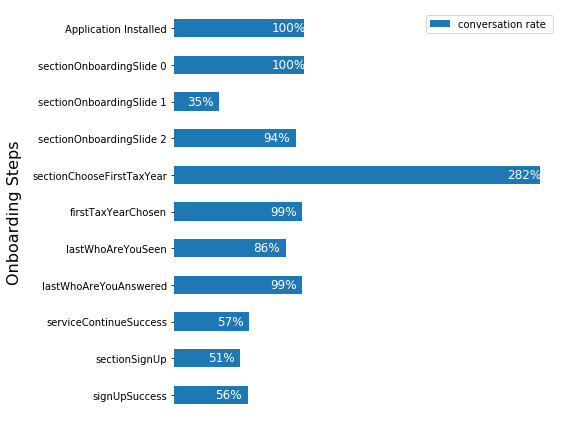

In [27]:
step_conv=step_conv[step_conv['event_text']!='appOpen']
ax2 = step_conv.plot.barh('event_text','conv_rate')
for i in ax2.patches:
    ax2.text(i.get_width()-.25, i.get_y()+.34, \
            str((int(i.get_width()*100)))+'%', fontsize=12, color='white')
    
ax2.set_ylabel("Onboarding Steps", fontsize=16,labelpad=10)
ax2.set_xlabel("Conversation rate", fontsize=16,labelpad=20)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.legend(['conversation rate '])
ax2.invert_yaxis()

#### Conclusions: 
1. sectionOnboardingSlide seems to be not helpful, users incline to skip them. Maybe those are not necessary, and we can set a A/B testing to see if removing them causes any user leaving
2. The drop from serviceContinueSuccess looks reasonable, since not all users are supported by the app.
3. However, half of users that are supported didn't sign up. Breaking down into each channel to figure out the reason 

#### Join table for analyzing on boarding process per channel( WITHOUT sectionOnboardingSlide )

In [28]:
join_table = pd.merge(user_channel,user_conv,on='anonymous_id')
join_table['timestamp']= pd.to_datetime(join_table['timestamp'],utc=True)

In [29]:
join_step_conv = join_table.groupby(['event_text','attributed_channel'])['anonymous_id'].nunique().reset_index(name='unique_user')
join_step_conv['event_text'] = pd.Categorical(join_step_conv['event_text'], funnel)
join_step_conv=join_step_conv.sort_values('event_text').dropna()
join_step_conv.reset_index(drop=True, inplace=True)
join_step_conv = join_step_conv.pivot(index='event_text',columns='attributed_channel',values='unique_user')

join_step_conv.fillna(0,inplace=True)

In [30]:
seg_plot = join_step_conv[['Organic','Facebook Installs','Instagram Installs','Off-Facebook Installs']].reset_index(level=[0])
seg_plot_nohelp= seg_plot[~seg_plot['event_text'].isin(['sectionOnboardingSlide 0','sectionOnboardingSlide 1','sectionOnboardingSlide 2'])]

/Users/Tison/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


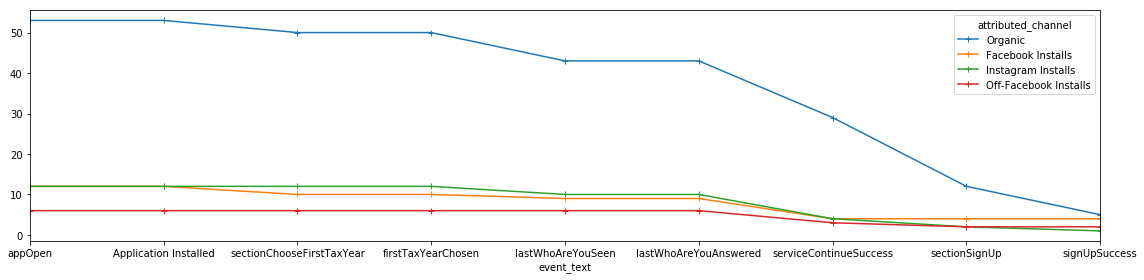

In [31]:
ax11 = seg_plot_nohelp.plot(x='event_text',figsize=(16, 4),marker='+', mfc='black')

> Look at users from Organic and has trigged serviceContinueSuccess

> put the user_id and the first time when they trigged serviceContinueSuccess into a dictory and find out the next event after serviceContinueSuccess

In [32]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
os = join_table[(join_table['attributed_channel']=='Organic')& (join_table['event_text']=='serviceContinueSuccess')].anonymous_id
ogranic_table = join_table[join_table['anonymous_id'].isin(os)]
ogranic_table.sort_values('timestamp')
ogranic_table['signup_success']= ogranic_table['event_text'].apply(lambda x: 1 if x =='sectionSignUp' else 0)
ogranic_table['continue_success']= ogranic_table['event_text'].apply(lambda x: 1 if x =='serviceContinueSuccess' else 0)

In [34]:
select_table = ogranic_table.copy()
select_table['continue_success']= select_table.apply(lambda x :1 if (x['signup_success'] == 1 or x['continue_success'] ==1)  else 0 ,axis=1)
id_not_sign = select_table.groupby(['anonymous_id']).agg({'continue_success':sum,'signup_success':sum}).reset_index().query('signup_success == 0').anonymous_id
table_not_sign = select_table[(select_table['signup_success']==0)&(select_table['continue_success']==1) ]
table= table_not_sign.drop_duplicates(subset='anonymous_id',keep='first')
time_mapper =dict(zip(table.anonymous_id, table.timestamp))

In [35]:
reason = select_table[select_table['anonymous_id'].isin(id_not_sign)]
result = reason.apply(lambda x: x if x['timestamp']>time_mapper[x['anonymous_id']] else pd.Series([]),axis=1).dropna()

#### The next pages after "serviceContinueSuccess"

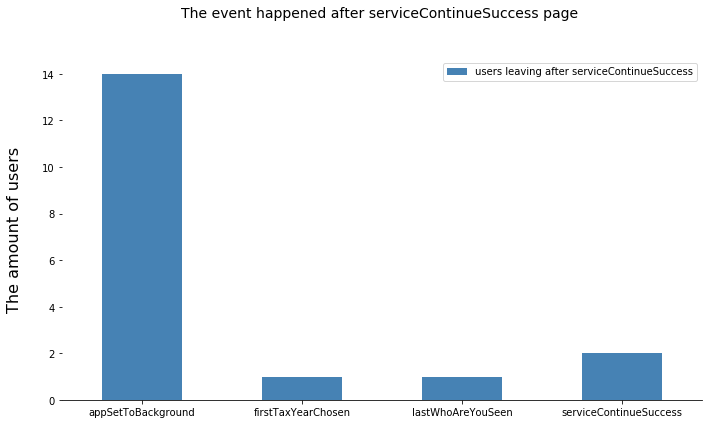

In [36]:
sorted_group = result.groupby('anonymous_id').apply(lambda x: x.sort_values(["timestamp"])).reset_index(drop=True)
top_3 = sorted_group.groupby('anonymous_id').head(1)
ax9 = top_3.groupby('event_text',as_index=False)['anonymous_id'].count().plot.bar('event_text',figsize=(10,6),color='steelblue',
                                                                                rot=0)
ax9.legend(['users leaving after serviceContinueSuccess'])


ax9.set_title("The event happened after serviceContinueSuccess page ", fontsize=14).set_position([.5, 1.1])
ax9.set_ylabel("The amount of users", fontsize=16,labelpad=20)
ax9.set_xlabel("", fontsize=16,labelpad=20)

ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)
ax9.spines['left'].set_visible(False)
plt.savefig('reason')


### (OPTIONAL )Time series 

In [37]:
join_table = pd.merge(user_channel,user_conv,on='anonymous_id')
join_table['timestamp']=pd.to_datetime(join_table['timestamp'],utc=True)

In [38]:
join_table['converted']=join_table.apply(lambda x: 1 if x['event_text']=='sectionSignUp' else 0, axis=1)
join_table['supported']=join_table.apply(lambda x: 1 if x['event_text']=='serviceContinueSuccess' else 0, axis=1)
join_table['date'] =join_table['timestamp'].dt.date
join_table['day'] = join_table['timestamp'].dt.to_period('d')
join_table['week'] =join_table['timestamp'].dt.to_period('w')


#### look at each day: total user coming in, the amount of user are eligible for service, and the amount of user are signedup 

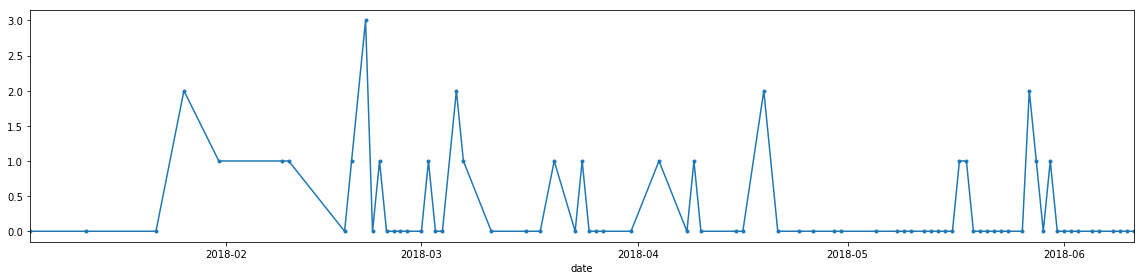

In [39]:
join_table.groupby('date')['converted'].sum().plot(figsize=(16,4),style='.-')

In [40]:
join_table_nur = join_table.drop_duplicates(subset=['anonymous_id','event_text'])

In [41]:
supported_df = pd.DataFrame(join_table_nur.groupby('day')['supported'].sum()).reset_index()
converted_df = pd.DataFrame(join_table_nur.groupby('day')['converted'].sum()).reset_index()
total_df =  pd.DataFrame(join_table_nur.groupby('day')['anonymous_id'].nunique()).reset_index().rename(columns={'anonymous_id':'total user'})
day_analysis  = total_df.merge(supported_df,on='day').merge(converted_df,on='day')

In [42]:
day_analysis['month'] =day_analysis['day'].dt.month
day_analysis['week'] =day_analysis['day'].dt.week

In [43]:
day_analysis['day']=day_analysis['day'].dt.strftime('%d')
day_analysis  = day_analysis.set_index('day')

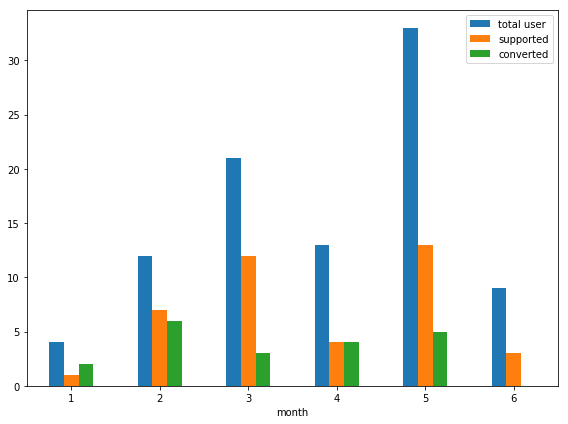

In [117]:
month_traffic = day_analysis.groupby('month')['total user','supported','converted'].sum().plot.bar(rot=0)

### take a look at everyday traffic 

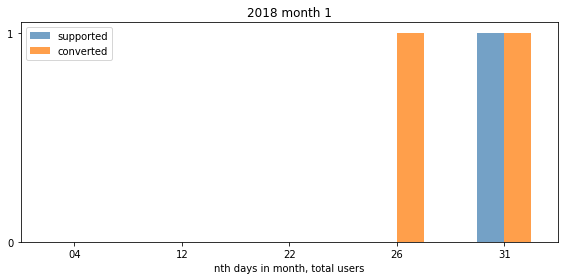

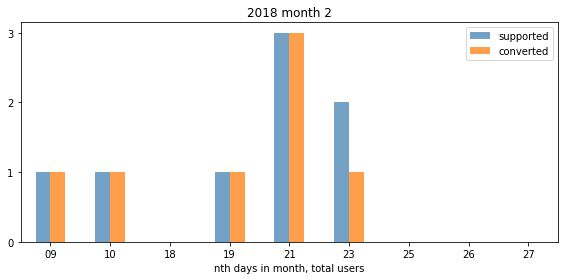

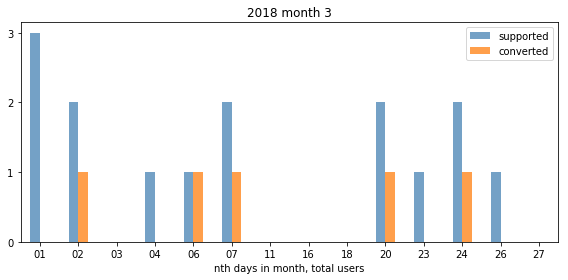

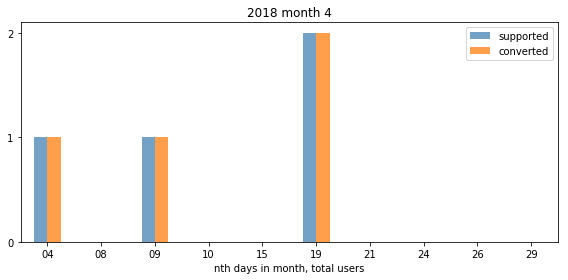

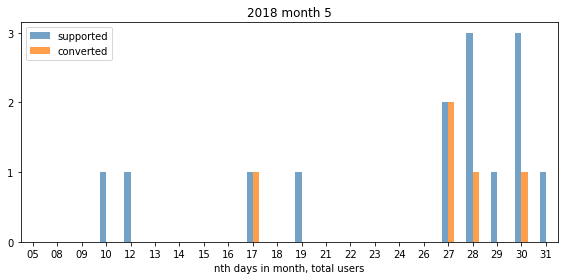

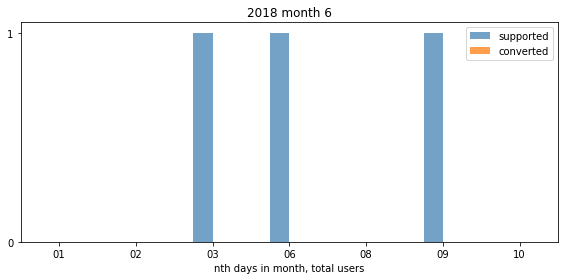

In [45]:
for i in day_analysis['month'].unique():
    month_analysis = day_analysis[day_analysis['month']== i][['supported','converted']]
    ax = month_analysis.plot.bar(figsize=(8,4),color=['steelblue','tab:orange'],alpha=0.75,rot=0)
    
    ax.set_yticks(np.arange(0,month_analysis['supported'].max()+1,1))
    
    ax.set_xlabel('nth days in month, total users')
    plt.title('2018 month {}'.format(i))
    
    #plt.savefig('month {}'.format(i))

#### Observation:
Month 3 and Month 5 have the a lot of coming users.

Maybe ads on facebook and instgram are working really well, let us confirm the assumption by breaking down the users into different channels 

In [160]:
converted_channel = ['Organic','Facebook Installs','Instagram Installs','Off-Facebook Installs']

In [149]:
supported_df = pd.DataFrame(join_table_nur.groupby(['day','attributed_channel'])['supported'].sum()).reset_index()
converted_df = pd.DataFrame(join_table_nur.groupby(['day','attributed_channel'])['converted'].sum()).reset_index()
total_df =  pd.DataFrame(join_table_nur.groupby(['day','attributed_channel'])['anonymous_id'].nunique()).reset_index().rename(columns={'anonymous_id':'total user'})


In [150]:
day_analysis  = total_df.merge(supported_df,on =['day','attributed_channel']).merge(converted_df,on=['day','attributed_channel'])

In [151]:
day_analysis['month'] =day_analysis['day'].dt.month
day_analysis['day']=day_analysis['day'].dt.strftime('%d')
day_analysis  = day_analysis.set_index('day')

In [152]:
day_analysis = day_analysis[day_analysis['attributed_channel'].isin(converted_channel)]

In [153]:
channel_m = list(day_analysis.attributed_channel.unique())* day_analysis.month.nunique()

In [154]:
m_channel = np.sort(list(np.arange(1,day_analysis.month.nunique()+1))* day_analysis.attributed_channel.nunique())


In [155]:
index = list(zip(*[channel_m,m_channel]))

In [156]:

full_channel = pd.DataFrame(index,columns=['attributed_channel','month'])

In [157]:
month_traffic = day_analysis.groupby(['attributed_channel','month'],as_index=False)['total user','supported','converted'].sum()

In [158]:
full_channel = full_channel.merge(month_traffic,on=['attributed_channel','month'],how='left').fillna(0).set_index(['attributed_channel','month'])


,total user,supported,converted
attributed_channel,,,
Organic,19.0,12.0,3.0
Instagram Installs,2.0,0.0,0.0
Facebook Installs,0.0,0.0,0.0
Off-Facebook Installs,0.0,0.0,0.0


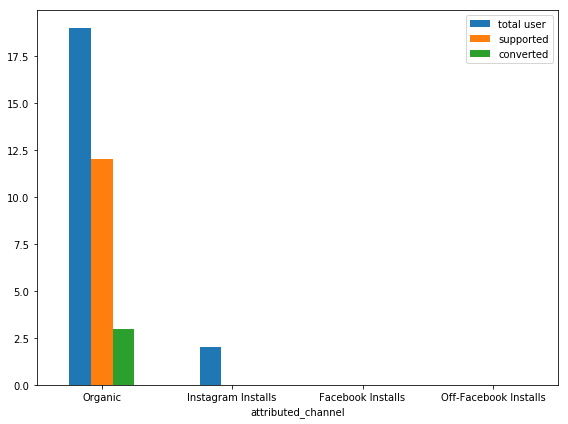

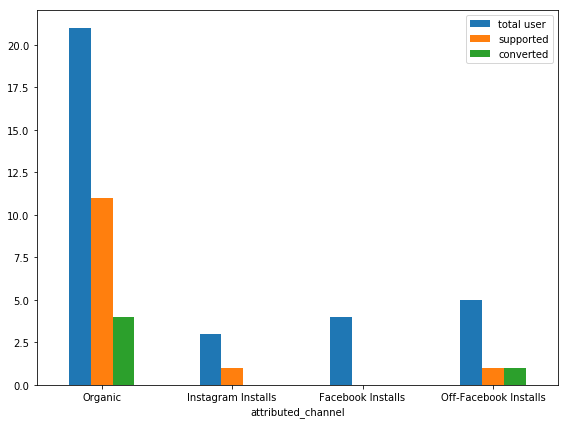

In [209]:
full_channel.xs(3,level='month').plot(kind='bar', rot=0)
full_channel.xs(5,level='month').plot(kind='bar', rot=0)

#### observeration:
Looking at Month 3, you will find out all the 

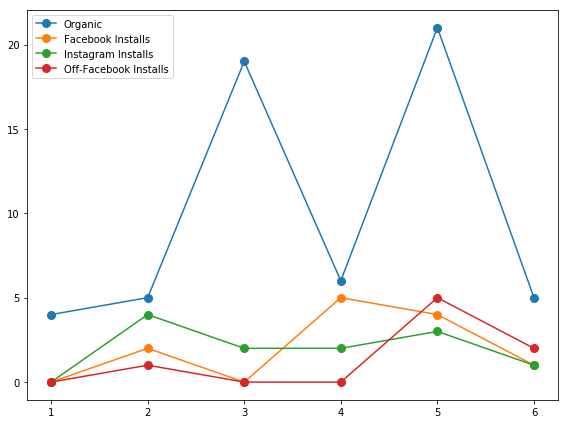

In [229]:
fig, ax = plt.subplots()
for index,i in enumerate(converted_channel):
    ax.plot(full_channel.loc[i]['total user'],label=i,marker='o', markersize=8, linestyle='-',linewidth=1.5)
ax.legend()

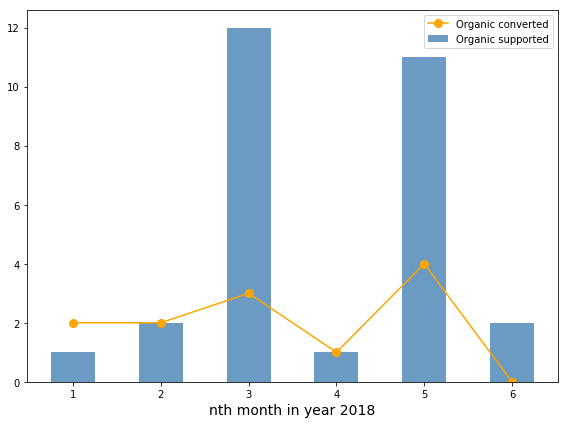

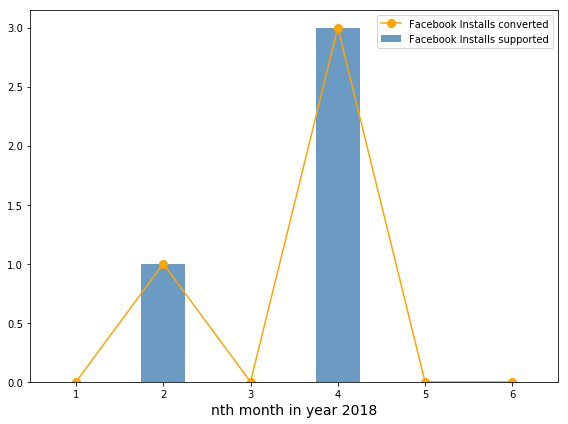

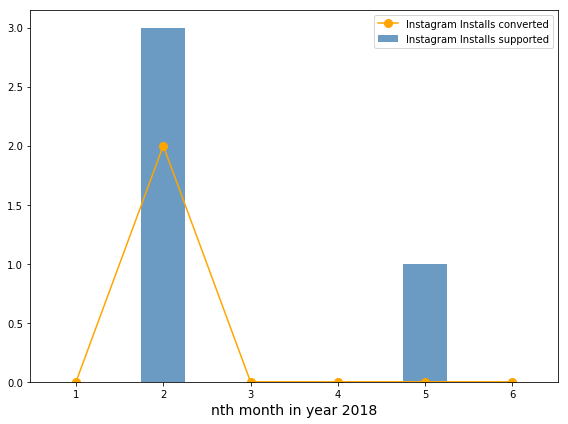

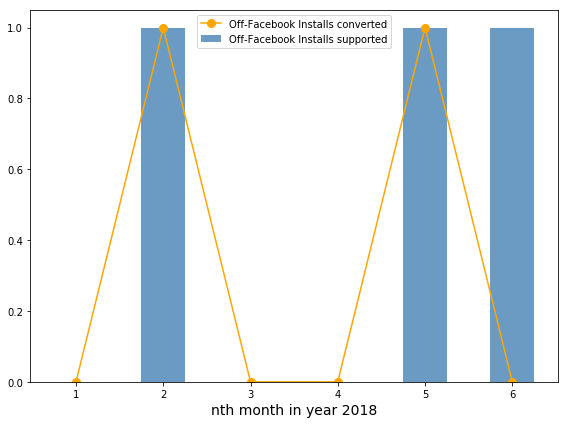

In [147]:

for index,i in enumerate(converted_channel):
    fig, ax = plt.subplots()
    ax.plot(full_channel.loc[i]['converted'],label=i + ' converted',marker='o', markersize=8, linestyle='-',linewidth=1.5, color='orange')
    ax.bar(full_channel.loc[i].index,full_channel.loc[i]['supported'],width=0.5, alpha=0.8, label=i+' supported',color ='steelblue' )
    ax.legend()
    ax.set_xlabel('nth month in year 2018',size=14)